In [1]:
print '主要是为了尝试一下 重构原图对conv5特征做约束对特征的影响,利用欧式距离计算损失吧'
print '如果这个实验效果不好的话，准备实现将conv1的特征加入conv5的特征做联合，再进行分类约束和重构约束'
import lib.Experiment as ex
from datasets.VOC_dataset_aug import VOC_dataset_aug_rec_conv5
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import numpy as np
from sklearn.metrics import average_precision_score
from torch.autograd.variable import Variable
import torch.utils.data
import torchvision.transforms as transforms
import networks.VGG16_rec_conv5 as vgg_model
from lib.loss import rec_conv5_criterion
import os
import networks.test as ts
def compute_mAP(labels,outputs):
    y_true = labels.cpu().numpy()
    y_pred = outputs.cpu().numpy()
    AP = []
    for i in range(y_true.shape[0]):
        AP.append(average_precision_score(y_true[i],y_pred[i]))
    return np.mean(AP)
ex_dir='./data/training_luo_rec_conv5_10582aug'
batch_size=4
workers=4
epoch_num=20
ex.check_dir(ex_dir)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
voc_train=VOC_dataset_aug_rec_conv5(train='train', transform=transforms.Compose([transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]), label_transform=None )
voc_val=VOC_dataset_aug_rec_conv5(train='val', transform=transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()]),
                    label_transform=None  )
train_loader = torch.utils.data.DataLoader(voc_train,
    batch_size=batch_size, shuffle=True,
    num_workers=workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(voc_val,
    batch_size=batch_size, shuffle=False,
    num_workers=workers, pin_memory=True)
print '加载数据集完成'

主要是为了尝试一下 重构原图对conv5特征做约束对特征的影响,利用欧式距离计算损失吧
如果这个实验效果不好的话，准备实现将conv1的特征加入conv5的特征做联合，再进行分类约束和重构约束
加载数据集完成


In [2]:
model=vgg_model.get_VGG_rec_conv5()
model.cuda()
#criterion = rec_conv5_criterion()
cls_criterion = nn.MultiLabelSoftMarginLoss()
# 重构损失 先用均方误差
rec_criterion=nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print '加载模型和损失完成'

加载模型和损失完成


开始训练
red==train;green==val...initial plt
train epoch 0 step 49,cls loss=0.097866,rec_loss=0.026429,loss=0.124295,mAp=86.2819
train epoch 0 step 99,cls loss=0.103319,rec_loss=0.025749,loss=0.129068,mAp=85.9522
train epoch 0 step 149,cls loss=0.102351,rec_loss=0.025191,loss=0.127542,mAp=85.5957
train epoch 0 step 199,cls loss=0.102773,rec_loss=0.025476,loss=0.128249,mAp=85.4079
train epoch 0 step 249,cls loss=0.103799,rec_loss=0.025202,loss=0.129001,mAp=85.0727
train epoch 0 step 299,cls loss=0.103662,rec_loss=0.025129,loss=0.128791,mAp=85.0888
train epoch 0 step 349,cls loss=0.102162,rec_loss=0.025157,loss=0.127318,mAp=85.1753
train epoch 0 step 399,cls loss=0.100278,rec_loss=0.025058,loss=0.125336,mAp=85.9187
train epoch 0 step 449,cls loss=0.102384,rec_loss=0.025036,loss=0.127421,mAp=85.4743
train epoch 0 step 499,cls loss=0.104006,rec_loss=0.024981,loss=0.128987,mAp=85.0816
train epoch 0 step 549,cls loss=0.104097,rec_loss=0.025095,loss=0.129192,mAp=85.2157
train epoch 0 step 599,cls

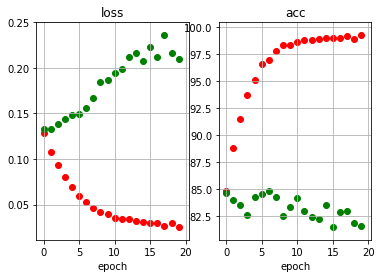

In [5]:
import matplotlib.pyplot as plt
print '开始训练'
print 'red==train;green==val...initial plt'
fig=plt.figure()
ax_loss=fig.add_subplot(1,2,1)
plt.title('loss')
plt.xlabel("epoch") 
ax_acc=fig.add_subplot(1,2,2)
plt.title('acc')
plt.xlabel("epoch")  
ax_loss.grid(True) #添加网格
ax_acc.grid(True) #添加网格
for t in range(epoch_num):
    model.train()
    mAP_train = []
    cls_loss_train= []
    rec_loss_train = []
    loss_train = []
    for i, (img,img_re,label) in enumerate(train_loader):
        img = img.cuda()
        label = label.cuda()
        img_re= img_re.cuda()
        label = Variable(label)
        input_img = Variable(img)
        img_re = Variable(img_re)
        
        score,fake_im = model(input_img)
        model.zero_grad()
        mAP_train.append(compute_mAP(label.data, score.data))#计算准确率
        cls_loss = cls_criterion(score,label)
        rec_loss=rec_criterion(fake_im,img_re)
        loss=torch.mean(cls_loss)+torch.mean(rec_loss)
        loss.backward()
        optimizer.step()
        loss_train.append(loss.data.cpu()[0])
        cls_loss_train.append(cls_loss.data.cpu()[0])
        rec_loss_train.append(rec_loss.data.cpu()[0])
        if (i+1)%50 == 0:
            print_str="train epoch %d step %d,cls loss=%.6f,rec_loss=%.6f,loss=%.6f,mAp=%.4f"
            print print_str%(t, i,np.mean(cls_loss_train),
                             np.mean(rec_loss_train),np.mean(loss_train),100 * np.mean(mAP_train))
    #绘图
    ax_loss.scatter(t,np.mean(loss_train),c='r')
    ax_acc.scatter(t,100 * np.mean(mAP_train),c='r')
    #测试
    model.eval()
    mAP_val = []
    cls_loss_val= []
    rec_loss_val = []
    loss_val= []
    for i, (img, img_re,label) in enumerate(val_loader):
        img = img.cuda()
        label = label.cuda()
        img_re = img_re.cuda()
        label = Variable(label)
        img_re = Variable(img_re)
        input_img = Variable(img)
        score,fake_im = model(input_img)
        mAP_val.append(compute_mAP(label.data, score.data))  # 计算准确率
        cls_loss = cls_criterion(score,label)
        rec_loss=rec_criterion(fake_im,img_re)
        loss=torch.mean(cls_loss)+torch.mean(rec_loss)
        loss_val.append(loss.data.cpu()[0])
        cls_loss_val.append(cls_loss.data.cpu()[0])
        rec_loss_val.append(rec_loss.data.cpu()[0])
        if (i+1)%20 == 0:
            print_str="val epoch %d step %d,cls loss=%.6f,rec_loss=%.6f,loss=%.6f,mAp=%.4f"
            print print_str%(t, i,np.mean(cls_loss_val),
                             np.mean(rec_loss_val),np.mean(loss_val),100 * np.mean(mAP_val))
    #绘图
    ax_loss.scatter(t,np.mean(loss_val),c='g')
    ax_acc.scatter(t,100 * np.mean(mAP_val),c='g')
    print('epoch %d done!'%t)
    model.save_v2(save_dir=ex_dir,epoch=t,train_stat=mAP_train,val_stat=mAP_val)